## __Uniformly hypocoercive and asymptotic preserving numerical scheme for linear kinetic equation__

In the following we discretize either the Fokker-Planck equation

$$\varepsilon\,\partial_t f^\varepsilon + v\cdot\nabla_x f^\varepsilon = \frac{1}{\varepsilon}\nabla_v\cdot\left(\mathcal{M}(v)\nabla_v\left(\frac{f^\varepsilon}{\mathcal{M}(v)}\right)\right)$$

either the relaxation (or linear BGK) equation

$$\varepsilon\,\partial_t f^\varepsilon + v\cdot\nabla_x f^\varepsilon = \frac{1}{\varepsilon}\left(\rho^\epsilon\mathcal{M}(v) - f^\varepsilon\right)\,,\qquad \rho^\varepsilon(t,x)\ =\ \int f^\varepsilon(t,x,v)\,\mathrm{d}v$$

where $\mathcal{M}$ is a gaussian Maxwellian distribution in the case of the Fokker-Planck equation and any symmetric probability distribution with finite up to forth order moment in the case of the BGK equation.  

In [1]:
from kinetic import * 
plt.rcParams['font.size'] = 20.0         # bigger font size
plt.rcParams['mathtext.fontset'] = 'cm'  # computer moder math font
plt.rcParams['text.usetex'] = True       # use tex engine for everything (useful for the axes labels)

In [2]:
equation = 1
if equation == 1:
    name = "kinetic_FP"
elif equation == 2:
    name = "BGK"
elif equation == 3:
    name = "Heavy-tailed BGK"
    
epsilon = 1

## Discretization of time, position and velocities

### Velocity discretization

The velocity domain is a bounded symmetric segment $[-v_{\star},v_{\star}]$. 
We consider a primal mesh of this interval composed of $N_v = 2L$ control volumes arranged symmetrically around $v = 0$. We thus get $2L+1$ distinct interface points denoted by $v_{j+\frac{1}{2}}$. In this way $v_{-L+1/2} = -v_{\star}$, $v_{1/2} = 0$ and $v_{j+1/2} = -v_{-j+1/2}$. Each cell has length $\Delta v_{j}=v_{j+\frac{1}{2}}-v_{j-\frac{1}{2}}$ and midpoint $v_j$.

In [3]:
vstar = 8 #right endpoint
L = 20 #number of positive velocity cells
(v,vhalf,dv,Nv,vmin,vmax) = discretizeV(L,vstar)

### Space discretization

In space, we consider a discretization of the torus $\mathbb{T}_{x_\star} = \mathbb{R}/x_\star\mathbb{Z}$ into $N_x$ subintervals of length $\Delta x_{i}$ and centers $x_{i}$.

In [4]:
xstar = np.pi #length of the domain
Nx = 51 #number of cells
(x,xhalf,dx,Nx,xmin,xmax) = discretizeX(Nx,xstar)

### Phase space discretization

In [5]:
(X,V,DV,DX,N) = discretizeXV(x,Nx,dx,v,Nv,dv)

### Time discretization

The time step $\Delta t$ is uniform until final time $T$

In [6]:
if equation == 1:
    dt = 0.01
    T  = max(20*epsilon, 15)  
else:
    dt = 0.02
    T  = max(50*epsilon, 15)    

## Discrete Maxwellian

In [7]:
if equation == 3:
    distrib = heavy
else:
    distrib = gaussian

(M,Mhalf,MM) = Maxwellian(equation,distrib, v, vhalf, dv, Nx)

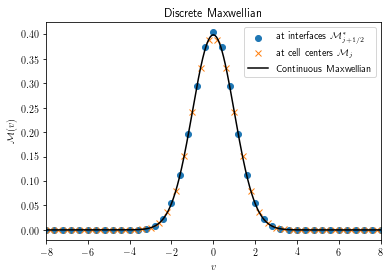

In [8]:
plt.figure
plt.xlabel('$v$')
plt.ylabel('$\mathcal{M}(v)$')
plt.xlim([vmin,vmax])
vplot = np.linspace(vmin,vmax,1000)
if equation == 1: 
    plt.plot(vhalf, Mhalf, label = 'at interfaces $\mathcal{M}_{j+1/2}^*$', marker = 'o', ls = 'None')
    Mplot = gaussian(vplot)
elif equation == 2:
    Mplot = gaussian(vplot)
elif equation == 3:
    Mplot = heavy(vplot)
Mass = np.sum(Mplot)*(vplot[2]-vplot[1])
Mplot = Mplot/Mass
plt.plot(v,M, label = 'at cell centers $\mathcal{M}_{j}$', marker = 'x', ls = 'None')
plt.plot(vplot, Mplot, label = "Continuous Maxwellian", color = 'black')
plt.title("Discrete Maxwellian")
plt.legend()
plt.show()

## Initial data and steady state

### Initial data 

In [9]:
testcase = 5

In [10]:
if testcase == 1:
    F = init_FullRandom(X,V)
elif testcase == 2:
    F = init_TruncatedRandom(X,V)
elif testcase == 3:
    F = init_ball(X,V,xstar,vstar)
elif testcase == 4:
    F = init_Oscillation(X,V,xstar)
elif testcase == 5:
    F = init_other(X,V,xstar)

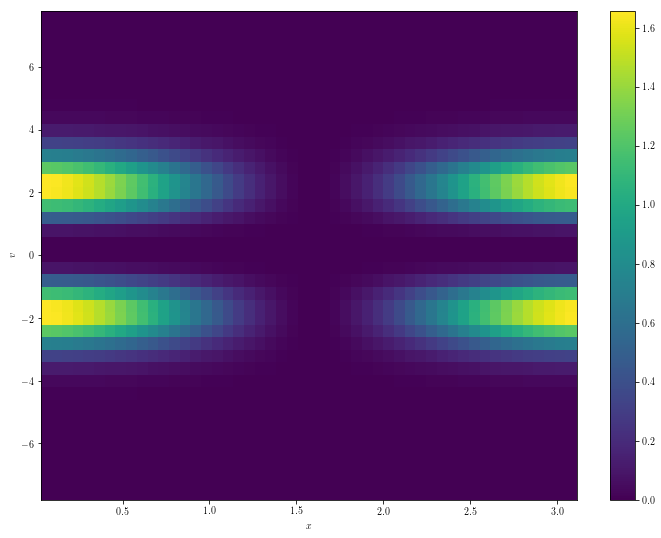

In [11]:
plt.rcParams['figure.figsize'] = 12, 9  # size of the inline plot, in inches
plt.pcolor(X,V,F, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')
plt.show()

### Steady state 
The steady state is a Maxwellian with the same mass as the initial data
$$
f^\infty_{ij}\ =\ m_f\,\mathcal{M}_j
$$
with 
$$
m_f = \frac{1}{x_\star}\sum_{i,j}f^0_{ij}\,\Delta x_i\,\Delta v_j
$$
so that 
$$
\sum_{i,j}(f^0_{ij}-f^\infty_{ij})\,\Delta x_i\,\Delta v_j\ =\ 0
$$

In [12]:
(Finf,mf) = SteadyState(F,MM,DX,DV,xstar)

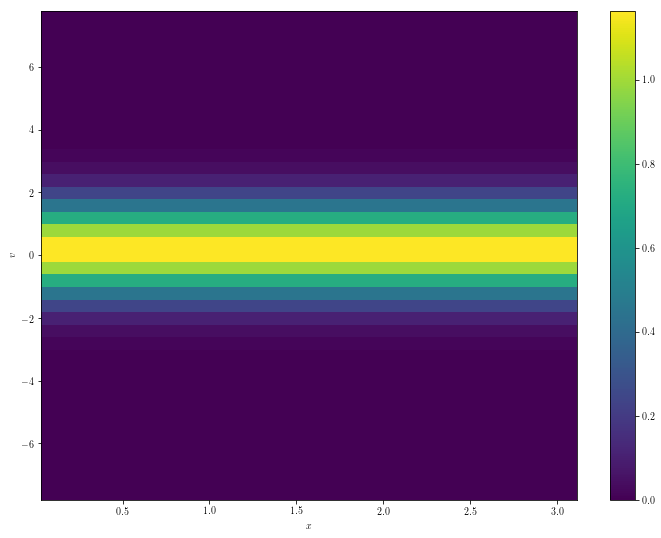

In [13]:
plt.rcParams['figure.figsize'] = 12, 9  # size of the inline plot, in inches
plt.pcolor(X,V,Finf, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')
plt.show()

### Computing other micro and macro unknowns

The macroscopic density is given by
$$
\rho_i^n\ =\ \sum_{j} f_{ij}^n\,\Delta v_j
$$
The micro unknown $(h_{ij}^n)$ and macro unknown $(\lambda_{i}^n)$ are such that
$$
 h_{ij}^n\ =\ \frac{1}{\varepsilon}\left(\frac{f_{ij}^n}{\mathcal{M}_j}  \,-\rho_i^n\right)
$$
$$
 \lambda_{i}^n\ =\ \rho_i^n - m_f
$$
The distribution function may be recovered by 
$$
 f_{ij}^n\ =\ m_f\,\mathcal{M}_j  + \lambda_i^n\,\mathcal{M}_j + \varepsilon\,h_{ij}^n\,\mathcal{M}_j
$$

In [14]:
(f,rho,Rho,h,H,lamb,Lamb,finf,rhoinf) = initAll(F, Finf, MM, DV, mf, epsilon)
unknown = np.concatenate((lamb,h))

### Initial data for the heat equation

In [15]:
rho_heat = rho.copy()
lamb_heat = lamb.copy()

## Building matrices  

### Matrices for the kinetic equation 
$$
 \mathbb{M}^\varepsilon\ =\ \left(\begin{matrix}
                              \mathbb{I}_{N} & \mathbb{M}^{\lambda, h}\\
                              \mathbb{M}^{h, \lambda} & \mathbb{M}^{h,h}\\
                              0 & \mathbb{N}^{h,h}                              
                            \end{matrix}\right)\,,\qquad 
                            \mathbb{D}^\varepsilon\ =\ \left(\begin{matrix}
                                                                \mathbb{I}_{N} & 0\\
								0 & \varepsilon^2 \mathbb{I}_{2L}\\
								0&0
								\end{matrix}\right)\,.
$$

In [16]:
(Mat, D) = kinMat(equation,M,Mhalf,v,dv,dx,dt,epsilon)

In [17]:
ResMat = invMat(Mat)@D 

### Matrix for heat equation

In [18]:
(Mat_heat,D_heat) = heatMat(M,v,dv,dx,dt)
ResMat_heat = invMat(Mat_heat)@D_heat 

## Solver

### Initiate control variates

In [19]:
# Evaluate control variates at initial time

(L1_init, L2h_init, L2lamb_init, L2f_init, L2lamb_heat_init) = diagnostic(F, H, lamb, lamb_heat, MM, DV, DX, epsilon)

L1 = [L1_init]
L2h = [L2h_init]
L2lamb = [L2lamb_init]
L2f = [L2f_init]
L2lamb_heat = [L2lamb_heat_init]
t = [0]

### Time loop

In [20]:
# Save the time evolution for output
Fn    = [F.copy()]
rhon  = [lamb.copy()+mf] 
rho_heatn = [rho.copy()]

i = 1
while t[-1] < T:
    
    # Solve kinetic equation
    unknown = ResMat@unknown
    
    # Solve heat equation
    lamb_heat = ResMat_heat@lamb_heat    
    
    # Update values  
    (f,F,rho,Rho,h,H,lamb,Lamb) = computeDens(unknown, MM, DV, mf, epsilon)
    
    # Save densities
    t.append(t[-1] + dt)
    Fn.append(F.copy())
    rhon.append(lamb.copy()+mf)
    rho_heatn.append(lamb_heat.copy()+mf)
  
    # Evaluate and save control variates
    (L1_tmp, L2h_tmp, L2lamb_tmp, L2f_tmp, L2lamb_heat_tmp) = diagnostic(F, H, lamb, lamb_heat, MM, DV, DX, epsilon)
    L1.append(L1_tmp)
    L2h.append(L2h_tmp)
    L2lamb.append(L2lamb_tmp)
    L2f.append(L2f_tmp)
    L2lamb_heat.append(L2lamb_heat_tmp)
    
    # Increment
    i = i + 1

# Transform into numpy arrays
L1 = np.array(L1)
L2h = np.array(L2h)
L2lamb = np.array(L2lamb)
L2f = np.array(L2f)
L2lamb_heat = np.array(L2lamb_heat)

### Plot control variates

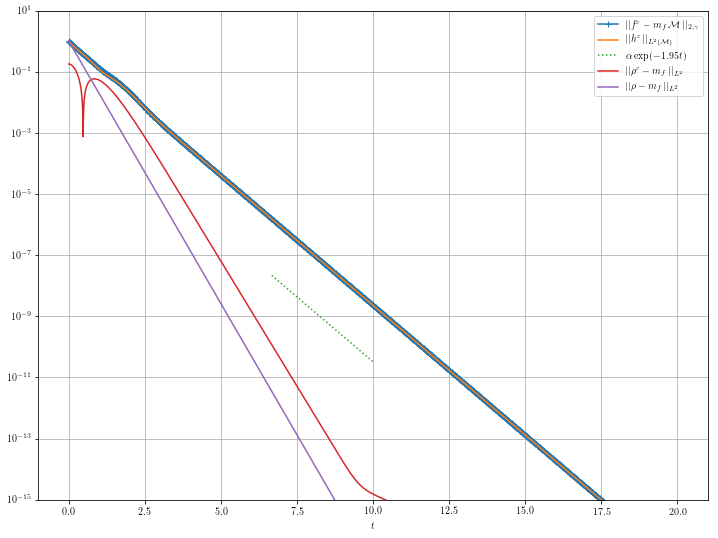

In [21]:
plt.rcParams['figure.figsize'] = 12, 9  # size of the inline plot, in inches

N1, N2 = len(t)//3, len(t)//2
### Return to equilibrium ###
rate = (np.log(L2f[N2]) - np.log(L2f[N1]))/(t[N2] - t[N1])

ax=plt.subplot(1,1,1)

plt.xlabel('$t$')
plt.semilogy(t,L2f/L2f[0],'-+', label = r'$||f^\varepsilon-m_f\,\mathcal{M}\,||_{2,\gamma}$')
plt.semilogy(t[1:],epsilon*L2h[1:]/L2f[0], label = r'$||h^\varepsilon\,||_{L^2(\mathcal{M})}$')
plt.semilogy(t[N1:N2],1e-2*np.exp(rate*np.array(t[N1:N2])), ':', label=r'$\alpha \exp({:0.2f}t)$'.format(rate))
plt.semilogy(t,L2lamb/L2f[0], label = r'$||\rho^\varepsilon-m_f\,||_{L^2}$')
plt.semilogy(t,L2lamb_heat/L2lamb_heat[0], label = r'$||\rho-m_f\,||_{L^2}$')
plt.ylim([1e-15,10])
plt.grid()


plt.legend()
plt.show()

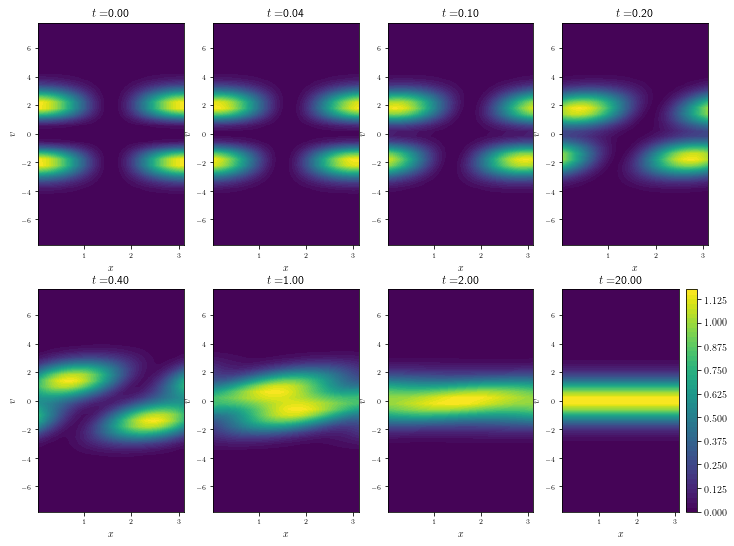

In [22]:
Nt = len(t)
time_indices = [0, len(t)//500, len(t)//200, len(t)//100, len(t)//50, len(t)//20, len(t)//10, len(t)-1]

### Snapshots of the distribution function ###
for i in range(2):
    for j in range(4):
        index = i + j*2
        plt.subplot(2,4,1+i + j*2)
        plt.contourf(X,V,Fn[time_indices[index]], 50, cmap=plt.cm.viridis)
        plt.title(r'$t = $'+('%.2f' % t[time_indices[index]]))
        plt.xlabel(r'$x$')
        plt.ylabel(r'$v$')
        plt.tick_params(axis='both', which='major', labelsize=7)
plt.colorbar()
plt.show()

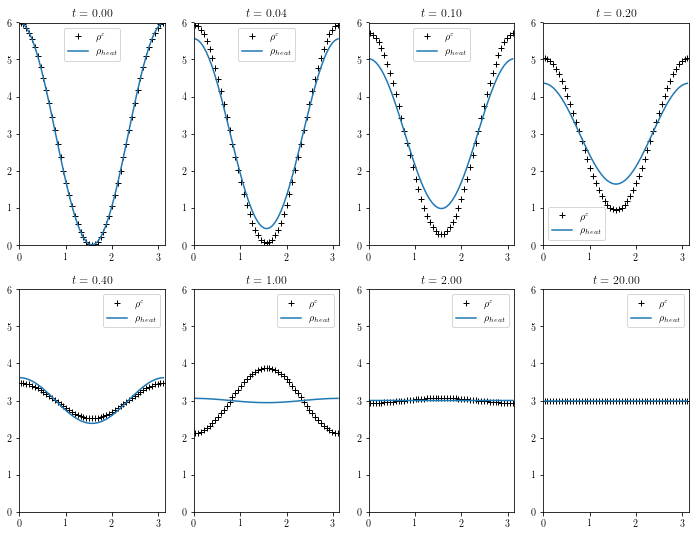

In [23]:
### Comparison between heat and kinetic ###
rho_max = np.max(rhon[0])
#rho_min = np.min(rhon[0])
for i in range(2):
    for j in range(4):
        index = i + j*2
        ax = plt.subplot(2,4,1+i + j*2)
        plt.plot(x,rhon[time_indices[index]], 'k+', label=r'$\rho^\varepsilon$')
        plt.plot(x,rho_heatn[time_indices[index]], '-', label=r'$\rho_{heat}$')
        plt.title(r'$t = '+('%.2f' % t[time_indices[index]])+'$')
        plt.ylim(0, rho_max)
        plt.xlim(0, xstar)
        plt.legend()
plt.show()
